# 3. Wavelet Coefficient Maps Generation Notebook

### This notebook is designed to generate wavelet coefficient maps for each frequency total maps. 


### 3.1 We first create the directory structure to store the outputs.

In [1]:
import os

def check_and_create_directories():
    """
    Checks for the existence of a nested directory structure and creates any missing directories.
    Prints a message whether the directory is created or already exists.

    The structure checked is:
    - wavelet_transform
      - maps
      - wavelets
        - wav_MW_maps
        - scal_coeffs
    """

    # Define the root directory and subdirectories
    root_dir = "wavelet_transform"
    sub_dirs = ["maps", "wavelets"]
    wavelet_sub_dirs = ["wav_MW_maps", "scal_coeffs"]

    # Check if root directory exists, create if not
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
        print(f"Created directory: {root_dir}")
    else:
        print(f"Directory already exists: {root_dir}")
    
    # Iterate over and create subdirectories in the root directory
    for sub_dir in sub_dirs:
        dir_path = os.path.join(root_dir, sub_dir)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
            print(f"Created directory: {dir_path}")
        else:
            print(f"Directory already exists: {dir_path}")
        
        # For the 'wavelets' directory, check and create nested subdirectories
        if sub_dir == "wavelets":
            for wavelet_sub_dir in wavelet_sub_dirs:
                nested_dir_path = os.path.join(dir_path, wavelet_sub_dir)
                if not os.path.exists(nested_dir_path):
                    os.mkdir(nested_dir_path)
                    print(f"Created directory: {nested_dir_path}")
                else:
                    print(f"Directory already exists: {nested_dir_path}")

# Run the function to check and create directories as needed
check_and_create_directories()


Directory already exists: wavelet_transform
Directory already exists: wavelet_transform/maps
Directory already exists: wavelet_transform/wavelets
Directory already exists: wavelet_transform/wavelets/wav_MW_maps
Directory already exists: wavelet_transform/wavelets/scal_coeffs


### 3.2 Functions used to generate wavelet coefficient maps.

wavelet_transform: Applies the wavelet transform to the input map using specified parameters (L_max, N_directions).
save_wavelet_scaling_coeffs: Saves the computed wavelet and scaling coefficients to .npy files.
load_wavelet_scaling_coeffs: Loads previously saved wavelet and scaling coefficients from files.
generate_wavelet_coeffs: The main function that reads a CMB map, converts it to spherical harmonic coefficients, applies the wavelet transform, saves the results, and visualizes the wavelet coefficient maps.

In [4]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
import skyclean as sc

def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if is_MW_alm:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    else:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
            print(MW_Pix_Map.shape)
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("ME alm shape:", original_map_alm.shape)


    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max-1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()

def hp_alm_2_mw_alm(hp_alm, L_max):
    """
    Converts spherical harmonics (alm) to a matrix representation for use in MW sampling.

    This function takes 1D Healpix spherical harmonics coefficients (alm) and converts them into a matrix form 
    that is in (MW sampling, McEwen & Wiaux) sampling. The matrix form is complex-valued 
    and indexed by multipole moment and azimuthal index.

    Parameters:
        hp_alm (numpy.ndarray): The input healpix spherical harmonics coefficients (alm).
        L_max (int): The maximum multipole moment to be represented in the output matrix.
    
    Note: # L_max = 4 | l = 0,1,2,3 , true lmax is L_max-1 = 3 | m = -3...0...(L_max-1 = 3)| number of m = 2(L_max-1)+1 = 2L_max-1

    Returns:
        MW_alm (numpy.ndarray): 2D array of shape (Lmax, 2*Lmax-1) MW spherical harmonics coefficients 
    """

    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm


def mw_alm_2_hp_alm(MW_alm, lmax):
    """
    Converts MW alm coefficients to HEALPix alm coefficients.

    Args:
        MW_alm (ndarray): 2D array of shape (Lmax, 2*Lmax-1) representing MW alm coefficients.
        lmax (int): Maximum multipole moment.

    Returns:
        ndarray: 1D array of HEALPix alm coefficients.
    """
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    return hp_alm

def wavelet_transform(mw_pix_map, L_max, N_directions):
    filter = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs = s2wav.analysis(mw_pix_map, N=N_directions, L=L_max, filters=filter, reality=False)
    return MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, wav_template = "wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{scale}_R{realization:04d}.npy"
                                , scal_template = "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_R{realization:04d}.npy"):
    
    # Save wavelet coefficients
    for scale, wav in enumerate(wavelet_coeffs):
        np_wav = np.array(wav)  # Convert JAX array to numpy array
        np.save(wav_template.format(frequency=frequency, scale=scale, realization=realization), np_wav)
    
    # Scaling coefficient is the same for all scales
    np_scaling = np.array(scaling_coeffs)  # Convert JAX array to numpy array
    np.save(scal_template.format(frequency=frequency, realization=realization), np_scaling)



def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization, wav_template = "wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{scale}_R{realization:04d}.npy",
                                scal_template = "wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequency}_R{realization:04d}.npy"):

    wavelet_coeffs = [np.real(np.load(wav_template.format(frequency=frequency, scale=scale, realization=realization))) for scale in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(scal_template.format(frequency=frequency, realization=realization)))
    return wavelet_coeffs, scaling_coeffs

def generate_wavelet_coeffs(CMB_map_path, frequency, L_max, N_directions, realization):
    # Step 1: Read the Healpix map
    healpix_map = hp.read_map(CMB_map_path)
    hp.mollview(healpix_map, title="Input CMB Map")
    # Step 2: Convert Healpix map to spherical harmonic coefficients
    hp_alm = hp.map2alm(healpix_map, L_max)

    # Step 3: Convert spherical harmonics to MW coefficients
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)
    visualize_MW_Pix_map(mw_alm, f"Original MW Map at Frequency {frequency}", is_MW_alm=True)  
    # Step 4: Transform MW coefficients back to a map (optional, based on use case)
    original_MW_Map = s2fft.inverse(mw_alm, L_max)
    # np.save(f'wavelet_transform/maps/Original_MW_Pix_map_F{frequency}_R{realization:04d}.npy', original_MW_Map)
    visualize_MW_Pix_map(original_MW_Map, f"Original MW Map at Frequency {frequency}")
    # Step 5: Apply wavelet transform to the MW map to get wavelet and scaling coefficients
    wavelet_coeffs, scaling_coeffs = wavelet_transform(original_MW_Map, L_max, N_directions)

    # Step 6: Save the wavelet and scaling coefficients
    save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization)

    # Step 7: Load the wavelet and scaling coefficients
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(frequency, len(wavelet_coeffs), realization)

    # Print shapes and graph for verification
    for scale in range(len(loaded_wavelet_coeffs)):
        print("wavelets shape", loaded_wavelet_coeffs[scale].shape)
        visualize_MW_Pix_map(loaded_wavelet_coeffs[scale], f"Wavelet Coefficient Map at Scale {scale}")
    return loaded_wavelet_coeffs, loaded_scaling_coeffs, original_MW_Map


### 3.3 Generate wavelet coefficient maps for CMB maps in batch

In [5]:
def process_cmb_data(L_max, N_directions, realization_list, frequencies, data_path_template):
    """
    Process CMB data and generate wavelets for each frequency and realization.

    Parameters:
    L_max (int): The maximum multipole moment.
    N_directions (int): The number of directions for the wavelets.
    realization_list (list): A list of realizations to process.
    frequencies (list): A list of frequency strings.
    data_path_template (str): Template for the data path with a placeholder for frequency.
    generate_wavelets (function): Function to generate wavelets, taking parameters CMB_map_path, frequency, L_max, N_directions, realization.
    """
    
       
    for realization in realization_list:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization}")
        for frequency in frequencies:
            print(f"Generate Wavelet coefficient map for frequency {frequency}")
            CMB_map_path = data_path_template.format(frequency=frequency, L_max = L_max, realization=realization_str)
            if not os.path.exists(CMB_map_path): 
                print(f"File {CMB_map_path} does not exist")
                continue 
            # wavelet_path = f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S5_R{realization_str}.npy"
            # if os.path.exists(wavelet_path): 
            #     print(f"File {wavelet_path} already exist")
            #     continue 
            wavelet, scal, original = generate_wavelet_coeffs(CMB_map_path, frequency, L_max, N_directions, realization)
            # return wavelet, scal, original
        # You can add any additional processing or saving logic here if needed


Processing realization 0
Generate Wavelet coefficient map for frequency 030


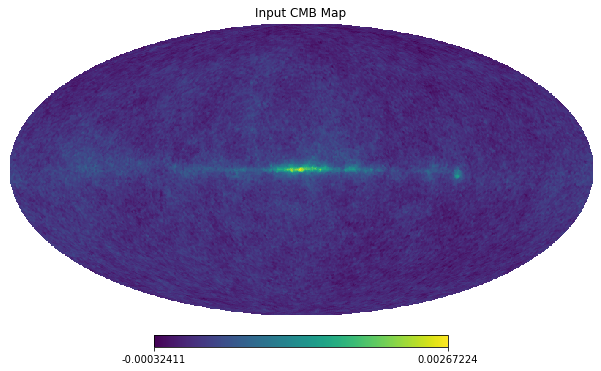

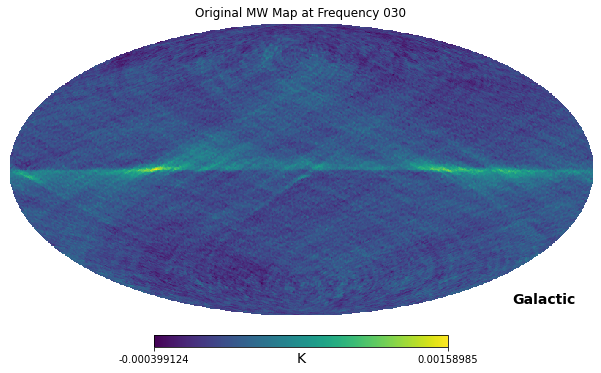

UnboundLocalError: local variable 'original_map_alm' referenced before assignment

In [6]:

# Example usage
# This L_max should match the L_max of the total map (CSN)
L_max = 256
N_directions = 1
realization_list = range(1)
frequencies = ["030"]
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
CSN_data_path_template = 'CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'

process_cmb_data(L_max, N_directions, realization_list, frequencies, CSN_data_path_template)


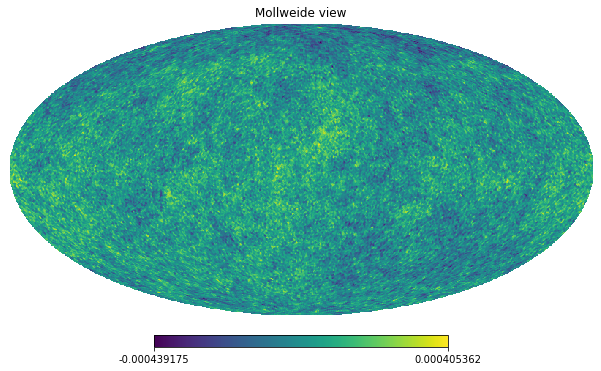

In [ ]:
L_max = 256
N_directions = 1
realization_list = range(1)
# frequencies = ["030"]
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
CSN_data_path_template = 'CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'
hp.mollview(hp.read_map(CSN_data_path_template.format(frequency="353", L_max = L_max, realization="0000")))

(256, 511)
ME alm shape: (256, 511)


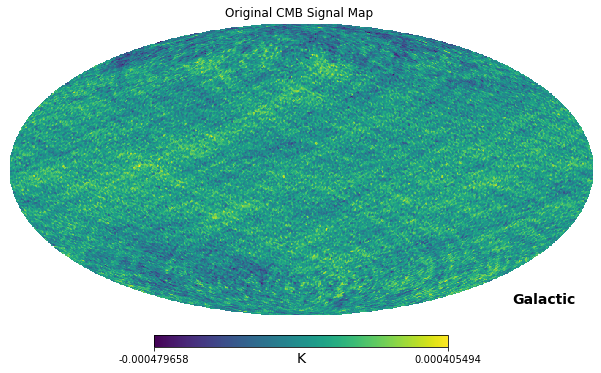

In [ ]:
from s2wav import filters
L_max = 256
N_directions = 1
filter = filters.filters_directional_vectorised(L_max, N_directions)
# f_scal = np.array([[0]]) #np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F030.npy") 
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F353_R0000.npy") 
# wav_template = "wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F{frequency}_S{scale}_R{realization:04d}.npy"
# wavelet_coeffs = [np.real(np.load(wav_template.format(frequency="030", scale=str(scale), realization="0"))) for scale in range(9)]

wavelet_coeffs = [np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_F353_S{i}_R0000.npy")) for i in range(9)]
# [np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_F{frequencies[i]}.npy") for i in range(len(frequencies))]

MW_Pix = s2wav.synthesis(wavelet_coeffs, L = L_max, f_scal = f_scal, filters = filter, N = 1)
print(MW_Pix.shape)
title = "Original CMB Signal Map "
visualize_MW_Pix_map(MW_Pix, title)